In [742]:
#importing the required libraries
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.metrics import r2_score

In [743]:
# Load the dataset
df=pd.read_csv('Car_Price_Prediction.csv')
df.head()

,Make,Model,Year,Engine Size,Mileage,Fuel Type,Transmission,Price
0,Honda,Model B,2015,3.9,74176,Petrol,Manual,30246.207931
1,Ford,Model C,2014,1.7,94799,Electric,Automatic,22785.747684
2,BMW,Model B,2006,4.1,98385,Electric,Manual,25760.290347
3,Honda,Model B,2015,2.6,88919,Electric,Automatic,25638.003491
4,Honda,Model C,2004,3.4,138482,Petrol,Automatic,21021.386657


In [744]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Make          1000 non-null   object 
 1   Model         1000 non-null   object 
 2   Year          1000 non-null   int64  
 3   Engine Size   1000 non-null   float64
 4   Mileage       1000 non-null   int64  
 5   Fuel Type     1000 non-null   object 
 6   Transmission  1000 non-null   object 
 7   Price         1000 non-null   float64
dtypes: float64(2), int64(2), object(4)
memory usage: 62.6+ KB


In [745]:
#dropping all the unwanted columns
df=df.drop(["Make","Model","Transmission"],axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Year         1000 non-null   int64  
 1   Engine Size  1000 non-null   float64
 2   Mileage      1000 non-null   int64  
 3   Fuel Type    1000 non-null   object 
 4   Price        1000 non-null   float64
dtypes: float64(2), int64(2), object(1)
memory usage: 39.2+ KB


In [746]:
df.isnull().sum()

Year           0
Engine Size    0
Mileage        0
Fuel Type      0
Price          0
dtype: int64

In [747]:
df.head()

,Year,Engine Size,Mileage,Fuel Type,Price
0,2015,3.9,74176,Petrol,30246.207931
1,2014,1.7,94799,Electric,22785.747684
2,2006,4.1,98385,Electric,25760.290347
3,2015,2.6,88919,Electric,25638.003491
4,2004,3.4,138482,Petrol,21021.386657


In [748]:
df.describe()

,Year,Engine Size,Mileage,Price
count,1000.000000,1000.000000,1000.00000,1000.000000
mean,2010.688000,2.798300,97192.48700,25136.615530
std,6.288577,1.024137,59447.31576,5181.401368
min,2000.000000,1.000000,56.00000,6704.953524
25%,2005.000000,1.900000,44768.75000,21587.878370
50%,2011.000000,2.800000,94411.50000,25189.325247
75%,2016.000000,3.700000,148977.75000,28806.368974
max,2021.000000,4.500000,199867.00000,41780.504635


In [749]:
df['Fuel Type'].unique()

array(['Petrol', 'Electric', 'Diesel'], dtype=object)

In [750]:
df['Mileage']=df['Mileage']/1000
df.head()

,Year,Engine Size,Mileage,Fuel Type,Price
0,2015,3.9,74.176,Petrol,30246.207931
1,2014,1.7,94.799,Electric,22785.747684
2,2006,4.1,98.385,Electric,25760.290347
3,2015,2.6,88.919,Electric,25638.003491
4,2004,3.4,138.482,Petrol,21021.386657


In [751]:
def parse_mileage(val):
    if pd.isna(val): 
        return None
    val = str(val).lower().strip()
    num = re.findall(r"[\d.]+", val)
    if not num:
        return None
    return float(num[0])
df["mileage_kmpl"] = df["Mileage"].apply(parse_mileage)
print(df[["Mileage", "mileage_kmpl"]].head())

   Mileage  mileage_kmpl
0   74.176        74.176
1   94.799        94.799
2   98.385        98.385
3   88.919        88.919
4  138.482       138.482


In [752]:
df["engine_cc"] = df["Engine Size"]*1000
df["engine_cc"]

0      3900.0
1      1700.0
2      4100.0
3      2600.0
4      3400.0
        ...  
995    1900.0
996    3100.0
997    1900.0
998    4400.0
999    2100.0
Name: engine_cc, Length: 1000, dtype: float64

In [753]:
# df['Mileage']=df['Fuel Type'].isin(['Petrol','Diesel']) & df['Mileage'].between(5,35)
# df.head()


In [754]:
clean_df = df[
    (df["Price"] > 1000) &
    (df["Year"].between(1980, 2025)) &
    (df["engine_cc"].between(600, 6000))
]
clean_df

,Year,Engine Size,Mileage,Fuel Type,Price,mileage_kmpl,engine_cc
0,2015,3.9,74.176,Petrol,30246.207931,74.176,3900.0
1,2014,1.7,94.799,Electric,22785.747684,94.799,1700.0
2,2006,4.1,98.385,Electric,25760.290347,98.385,4100.0
3,2015,2.6,88.919,Electric,25638.003491,88.919,2600.0
4,2004,3.4,138.482,Petrol,21021.386657,138.482,3400.0
...,...,...,...,...,...,...,...
995,2002,1.9,5.445,Petrol,22765.597091,5.445,1900.0
996,2020,3.1,149.112,Diesel,30392.575567,149.112,3100.0
997,2008,1.9,195.387,Petrol,16446.892292,195.387,1900.0
998,2003,4.4,0.246,Petrol,27396.156708,0.246,4400.0


In [755]:
if "mileage_kmpl" in clean_df.columns:
    clean_df = clean_df[
        ((clean_df["Fuel Type"].isin(["petrol", "diesel"])) &
         (clean_df["mileage_kmpl"].between(5, 35))) |
        ((clean_df["Fuel Type"] == "electric") &
         (clean_df["mileage_kmpl"].between(50, 600)))
    ]

In [756]:
clean_df

,Year,Engine Size,Mileage,Fuel Type,Price,mileage_kmpl,engine_cc


In [757]:
def parse_mileage2(val):
    if pd.isna(val):
        return None
    val = str(val).lower().strip()

    # Extract numeric value (handles commas and decimals)
    match = re.findall(r"[\d,.]+", val)
    if not match:
        return None
    
    num = match[0].replace(",", "")
    try:
        return float(num)
    except:
        return None

# Apply function
df["mileage_num"] = df["Mileage"].apply(parse_mileage2)

print(df[["Mileage", "mileage_num"]].head(10))


   Mileage  mileage_num
0   74.176       74.176
1   94.799       94.799
2   98.385       98.385
3   88.919       88.919
4  138.482      138.482
5   81.462       81.462
6  179.340      179.340
7  165.320      165.320
8   31.159       31.159
9   42.039       42.039


In [758]:
print(df["Mileage"].median())

94.4115


In [759]:
clean_df = df.copy()

# Price filter
clean_df = clean_df[clean_df["Price"].between(1000, 1e8)]

# Year filter
clean_df = clean_df[clean_df["Year"].between(1980, 2025)]

# Engine filter
clean_df = clean_df[clean_df["engine_cc"].between(600, 6000)]

# Odometer filter (km driven)
clean_df = clean_df[clean_df["mileage_num"].between(0, 1_000_000)]
# clean_df.rename(columns={"mileage_num": "Mileage"}, inplace=True)

clean_df.reset_index(drop=True, inplace=True)

print("After cleaning:", clean_df.shape)


After cleaning: (1000, 8)


In [760]:
clean_df

,Year,Engine Size,Mileage,Fuel Type,Price,mileage_kmpl,engine_cc,mileage_num
0,2015,3.9,74.176,Petrol,30246.207931,74.176,3900.0,74.176
1,2014,1.7,94.799,Electric,22785.747684,94.799,1700.0,94.799
2,2006,4.1,98.385,Electric,25760.290347,98.385,4100.0,98.385
3,2015,2.6,88.919,Electric,25638.003491,88.919,2600.0,88.919
4,2004,3.4,138.482,Petrol,21021.386657,138.482,3400.0,138.482
...,...,...,...,...,...,...,...,...
995,2002,1.9,5.445,Petrol,22765.597091,5.445,1900.0,5.445
996,2020,3.1,149.112,Diesel,30392.575567,149.112,3100.0,149.112
997,2008,1.9,195.387,Petrol,16446.892292,195.387,1900.0,195.387
998,2003,4.4,0.246,Petrol,27396.156708,0.246,4400.0,0.246


<Axes: ylabel='Price'>

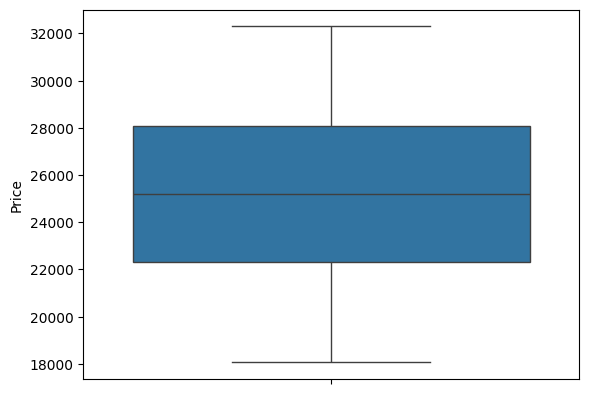

In [761]:
q1=df['Price'].quantile(0.25)
q3=df['Price'].quantile(0.75)
IQR=q3-q1
low_boun=q1-0.5*IQR
up_boun=q3+0.5*IQR
df=df[(df['Price']>=low_boun)&(df['Price']<=up_boun)]
sns.boxplot(y='Price',data=df)

In [762]:
# df.reset_index(inplace=True)
# df=df.drop('index',axis=1)
copied_dataset=df.copy()
from sklearn.preprocessing import LabelEncoder
obj=LabelEncoder()
clean_df['Fuel Type']=obj.fit_transform(clean_df['Fuel Type'])
df.head()

,Year,Engine Size,Mileage,Fuel Type,Price,mileage_kmpl,engine_cc,mileage_num
0,2015,3.9,74.176,Petrol,30246.207931,74.176,3900.0,74.176
1,2014,1.7,94.799,Electric,22785.747684,94.799,1700.0,94.799
2,2006,4.1,98.385,Electric,25760.290347,98.385,4100.0,98.385
3,2015,2.6,88.919,Electric,25638.003491,88.919,2600.0,88.919
4,2004,3.4,138.482,Petrol,21021.386657,138.482,3400.0,138.482


In [763]:
clean_df=clean_df.drop(["mileage_kmpl","engine_cc","mileage_num"],axis=1)
clean_df

,Year,Engine Size,Mileage,Fuel Type,Price
0,2015,3.9,74.176,2,30246.207931
1,2014,1.7,94.799,1,22785.747684
2,2006,4.1,98.385,1,25760.290347
3,2015,2.6,88.919,1,25638.003491
4,2004,3.4,138.482,2,21021.386657
...,...,...,...,...,...
995,2002,1.9,5.445,2,22765.597091
996,2020,3.1,149.112,0,30392.575567
997,2008,1.9,195.387,2,16446.892292
998,2003,4.4,0.246,2,27396.156708


In [764]:
X=clean_df.drop('Price',axis=1)
y=clean_df['Price']
# clean_df

In [765]:
Xtrain,Xtest,ytrain,ytest=train_test_split(X,y,test_size=0.3,random_state=42)
model=RandomForestRegressor(random_state=42)
params={
    "n_estimators":[100,200,300,500],
    "max_depth":[3,4,5,6]
}

In [766]:
grid=GridSearchCV(estimator=model,param_grid=params,cv=10)
grid.fit(Xtrain,ytrain)

,estimator,RandomForestR...ndom_state=42)
,param_grid,"{'max_depth': [3, 4, ...], 'n_estimators': [100, 200, ...]}"
,scoring,None
,n_jobs,None
,refit,True
,cv,10
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,500


In [767]:
print('training efficiency:',grid.score(Xtrain,ytrain))
print('testing efficiency:',grid.score(Xtest,ytest))

training efficiency: 0.9033195432647123
testing efficiency: 0.7940784103772168


In [768]:
Lr_model=LinearRegression()
Lr_model.fit(Xtrain,ytrain)
print('training efficiency:',Lr_model.score(Xtrain,ytrain))
print('testing efficiency:',Lr_model.score(Xtest,ytest))

training efficiency: 0.84444947311787
testing efficiency: 0.826282652514216


In [769]:
R_model=Ridge(alpha=5)
R_model.fit(Xtrain,ytrain)

,alpha,5
,fit_intercept,True
,copy_X,True
,max_iter,None
,tol,0.0001
,solver,'auto'
,positive,False
,random_state,None


In [770]:
print('training efficiency:',R_model.score(Xtrain,ytrain))
print('testing efficiency:',R_model.score(Xtest,ytest))

training efficiency: 0.8444424598345485
testing efficiency: 0.8265002358961985


In [771]:
L_model=Lasso(alpha=1000)
L_model.fit(Xtrain,ytrain)

,alpha,1000
,fit_intercept,True
,precompute,False
,copy_X,True
,max_iter,1000
,tol,0.0001
,warm_start,False
,positive,False
,random_state,None
,selection,'cyclic'


In [772]:
print('training efficiency:',L_model.score(Xtrain,ytrain))
print('testing efficiency:',L_model.score(Xtest,ytest))

training efficiency: 0.8084980588065992
testing efficiency: 0.8054675566812952


In [773]:
with open('RFmodel.pkl','wb') as file:
    pickle.dump(Lr_model,file)

In [774]:
copied_dataset.to_csv('copied.csv')

In [775]:
import sklearn
sklearn.__version__

'1.7.1'

In [776]:
copied_dataset

,Year,Engine Size,Mileage,Fuel Type,Price,mileage_kmpl,engine_cc,mileage_num
0,2015,3.9,74.176,Petrol,30246.207931,74.176,3900.0,74.176
1,2014,1.7,94.799,Electric,22785.747684,94.799,1700.0,94.799
2,2006,4.1,98.385,Electric,25760.290347,98.385,4100.0,98.385
3,2015,2.6,88.919,Electric,25638.003491,88.919,2600.0,88.919
4,2004,3.4,138.482,Petrol,21021.386657,138.482,3400.0,138.482
...,...,...,...,...,...,...,...,...
994,2015,2.9,52.800,Petrol,30804.200417,52.800,2900.0,52.800
995,2002,1.9,5.445,Petrol,22765.597091,5.445,1900.0,5.445
996,2020,3.1,149.112,Diesel,30392.575567,149.112,3100.0,149.112
998,2003,4.4,0.246,Petrol,27396.156708,0.246,4400.0,0.246
